<a href="https://colab.research.google.com/github/ahatesham02/Bangla-Image-Captioning/blob/main/Few_shot_2_learning_with_bornonImage_Captioning_with_Bahdanau_Attention_(Bidirectional_GRU)_Bancap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import string
import keras
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.backend import set_session
import sys, time, os, warnings 
warnings.filterwarnings("ignore")
import re

import numpy as np
import pandas as pd 
from PIL import Image
import pickle
from collections import Counter
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.utils import load_img, img_to_array
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

!unzip -qq Flickr8k_Dataset.zip

^C
replace Flicker8k_Dataset/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
! pip install bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.6 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import bnlp
from bnlp.corpus import  punctuations, letters, digits

punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Thesis/Flicker8k Bangla/BAN-Cap_captiondata.csv')

FileNotFoundError: ignored

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data.head(15)

In [ ]:
def create_vocabulary(data):
  vocab = []
  for captions in data.bengali_caption.values:
    vocab.extend(captions.split())
  print("Vocabulary Size : {}".format(len(set(vocab))))
  return vocab

In [ ]:
vocabulary = create_vocabulary(data)

In [ ]:
table = str.maketrans('', '', punctuations)
desc = [w.translate(table) for w in data.bengali_caption]

In [ ]:
def cleaning(row):
  text = re.sub('[^\u0980-\u09FF]',' ', row) 
  return text

In [ ]:
data['bengali_caption'] = data.bengali_caption.apply(cleaning)

In [ ]:
data.head(10)

In [ ]:
clean_vocabulary = create_vocabulary(data)

In [ ]:
from os import listdir
## The location of the Flickr8K_ photos
image_dir = '/content/Flicker8k_Dataset'
images = listdir(image_dir)

In [ ]:
def clean(col):
  text = col.split('#')[0]
  return text
  
  

In [ ]:
data2 = data.copy()

In [ ]:
data2.head(10)

In [ ]:
data2['caption_id'] = data2.caption_id.apply(lambda x : x.split('#')[0])

In [ ]:
data2.head(10)

In [ ]:
data[7000:7010]

In [ ]:
data2.shape

In [ ]:
data3 = data2[:40000]

In [ ]:
data3.shape

In [ ]:
def preprocess_images(data):
  img_name_vector = []

  for filenames in data3["caption_id"]:
      full_image_path = image_dir+"/"+ filenames
      img_name_vector.append(full_image_path)
  return img_name_vector
img_name_vector = preprocess_images(data)
img_name_vector[:10]

In [ ]:
def preprocess_captions(data):
  total_captions = []

  for caption  in data3["bengali_caption"].astype(str):
      caption = '<start> ' + caption+ ' <end>'
      total_captions.append(caption)
  return total_captions
total_captions = preprocess_captions(data)
total_captions[:10]

In [ ]:
"""def data_limiter(num,total_captions,img_name_vector):
  # Shuffle captions and image_names together
  train_captions, img_name_vector = shuffle(total_captions,img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector"""

In [ ]:
#total_captions,img_name_vector = data_limiter(40000,total_captions,img_name_vector)

In [ ]:
len(total_captions)

In [ ]:
from pickle import dump

# save to file
dump(total_captions, open('bengali_captions.pkl', 'wb'))
dump(img_name_vector, open('bengali_img_names.pkl', 'wb'))

In [ ]:
from pickle import load

In [4]:
total_captions = load(open('/content/drive/MyDrive/NLP dataset/Bancap/bancap_captions.pkl', 'rb'))
img_name_vector = load(open('/content/drive/MyDrive/NLP dataset/Bancap/bancap_img_names.pkl', 'rb'))

In [ ]:
len(img_name_vector)

40000

##Bornon Dataset

In [5]:
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [6]:
import zipfile
exfile= '/content/drive/MyDrive/NLP dataset/Bornon/Bornon Images-20221222T175856Z-001.zip'
zip_ref = zipfile.ZipFile(exfile, 'r')
zip_ref.extractall()
zip_ref.close()

In [6]:
from os import listdir
## The location of the Flickr8K_ photos
image_dir = '/content/Bornon Images'
images = listdir(image_dir)

## The location of the caption file
descriptions_dir = '/content/drive/MyDrive/Thesis/Bornon/bornon_train_token.txt'
print("The number of jpg flies in Bornon: {}".format(len(images)))

The number of jpg flies in Bornon: 4106


## Bancap + Bornon (1000)

In [7]:
train_captions_bornon = load(open('/content/drive/MyDrive/NLP dataset/Bornon/bornon_captions.pkl', 'rb'))
img_name_vector_bornon = load(open('/content/drive/MyDrive/NLP dataset/Bornon/bornon_img_names.pkl', 'rb'))

In [8]:
len(img_name_vector_bornon)

20439

In [9]:
bornon_train, bornon_test, bornon_cap_train, bornon_cap_test = train_test_split(img_name_vector_bornon, train_captions_bornon, test_size = 0.1, random_state = 42)

In [10]:
len(bornon_train)

18395

In [11]:
len(bornon_train[:9196])

9196

In [12]:
train_captions1 = total_captions[:30000] + bornon_cap_train[:9196]
img_name_vector1 = img_name_vector[:30000] + bornon_train[:9196]

In [13]:
# To know the shape of images
def img_shape_finder(image):
  img= plt.imread(image)

  print("Shape of the image ==> {0} is ==> {1}".format(image.split('/')[1],img.shape))

In [14]:
img_list=[]
for i in range(20):
  img_list.append(img_name_vector[i])

In [15]:
for j in img_list:
  img_shape_finder(j)

Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (500, 375, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (375, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (400, 500, 3)
Shape of the image ==> content is ==> (410, 500, 3)
Shape of the image ==> content is ==> (410, 500, 3)
Shape of the image ==> content is ==> (410, 500, 3)
Shape of the image ==> content is ==> (410, 500, 3)
Shape of the

In [16]:
import tensorflow as tf

In [17]:
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

In [18]:
image_model = ResNet50(include_top=False,weights='imagenet')
new_input = image_model.input 
hidden_layer = image_model.layers[-1].output  
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)

In [19]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [20]:
preprocessed_image = []
IMAGE_SHAPE = (224, 224)

In [21]:
for img in img_name_vector1[0:5] :
    img = tf.io.read_file(img, name=None)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.resnet50.preprocess_input(img)
    preprocessed_image.append(img)

Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)
Shape after resize :  (224, 224, 3)


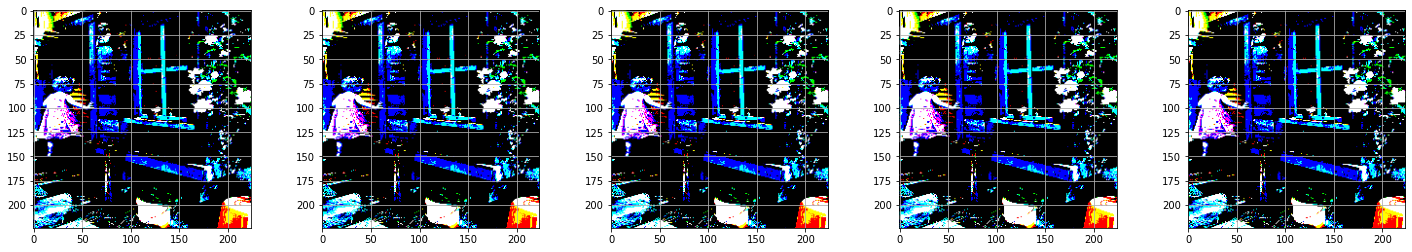

In [22]:
# checking first five images post preprocessing
Display_Images = preprocessed_image[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(25)
for ax, image in zip(axes, Display_Images) :
  print('Shape after resize : ', image.shape)
  ax.imshow(image)
  ax.grid('off')

Shape after resize : (224, 224, 3)


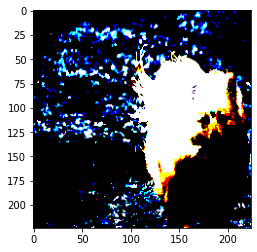

In [23]:
def load_images(image_path) :
  img = tf.io.read_file(image_path, name = None)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, IMAGE_SHAPE)
  img = tf.keras.applications.resnet50.preprocess_input(img)
  return img, image_path

img1,img1_path = load_images("Flicker8k_Dataset/3439243433_d5f3508612.jpg")
print("Shape after resize :", img1.shape)
plt.imshow(img1)

In [24]:

tokenizer = tf.keras.preprocessing.text.Tokenizer(
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions1)
train_seqs = tokenizer.texts_to_sequences(train_captions1)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions1)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [25]:
vocab_size = len(tokenizer.index_word)+1

In [26]:
vocab_size

15099

In [27]:
train_captions1[:3]

['<start> একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্রবেশ পথের সিঁড়ি বেয়ে উঠছে  <end>',
 '<start> একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে <end>',
 '<start> একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে   <end>']

In [28]:
train_seqs[:3]

[[2, 4, 228, 39, 26, 37, 48, 4, 761, 1304, 889, 890, 175, 157, 3],
 [2, 4, 48, 41, 4, 139, 7599, 3295, 3],
 [2, 4, 37, 24, 139, 3721, 157, 3]]

In [29]:
tokenizer.index_word

{1: '<unk>',
 2: '<start>',
 3: '<end>',
 4: 'একটি',
 5: 'আছে',
 6: 'একজন',
 7: 'কুকুর',
 8: 'লোক',
 9: 'এক',
 10: 'যাচ্ছে',
 11: 'করছে',
 12: 'এবং',
 13: 'দেখা',
 14: 'সাদা',
 15: 'উপর',
 16: 'কালো',
 17: 'বসে',
 18: 'দুটি',
 19: 'মহিলা',
 20: 'খেলছে',
 21: 'ও',
 22: 'কিছু',
 23: 'লাল',
 24: 'তার',
 25: 'ছেলে',
 26: 'পরা',
 27: 'দিয়ে',
 28: 'রঙের',
 29: 'ছোট',
 30: 'নীল',
 31: 'পাশে',
 32: 'মধ্যে',
 33: 'দাঁড়িয়ে',
 34: 'পরিহিত',
 35: 'নিয়ে',
 36: 'সামনে',
 37: 'বাচ্চা',
 38: 'দৌড়াচ্ছে',
 39: 'জামা',
 40: 'ব্যক্তি',
 41: 'শিশু',
 42: 'পরে',
 43: 'লাফ',
 44: 'দিকে',
 45: 'দিচ্ছে',
 46: 'করে',
 47: 'মানুষ',
 48: 'মেয়ে',
 49: 'থেকে',
 50: 'ধরে',
 51: 'কুকুরটি',
 52: 'দিয়ে',
 53: 'ছবি',
 54: 'দাঁড়িয়ে',
 55: 'ঘাসের',
 56: 'সবুজ',
 57: 'বল',
 58: 'বাদামী',
 59: 'পানিতে',
 60: 'সাথে',
 61: 'নিয়ে',
 62: 'জন্য',
 63: 'হলুদ',
 64: 'দুই',
 65: 'মাঠে',
 66: 'একদল',
 67: 'দুজন',
 68: 'মুখে',
 69: 'মেয়ে',
 70: 'লোকটি',
 71: 'হাতে',
 72: 'বালক',
 73: 'রয়েছে',
 74: 'সাইকেল',
 75: 'দেখছে',
 76: 'এ

In [30]:
# Pad each vector to the max_length of the captions  store it to a vairable

train_seqs_len = [len(seq) for seq in train_seqs]

longest_word_length = max(train_seqs_len)

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding= 'post', maxlen = longest_word_length,
                                                          dtype='int32', value=0)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(39196, 34)


In [31]:
cap_vector

array([[   2,    4,  228, ...,    0,    0,    0],
       [   2,    4,   48, ...,    0,    0,    0],
       [   2,    4,   37, ...,    0,    0,    0],
       ...,
       [   2,    4, 1896, ...,    0,    0,    0],
       [   2,  326,  218, ...,    0,    0,    0],
       [   2,  195,   47, ...,    0,    0,    0]], dtype=int32)

In [32]:
len(cap_vector)

39196

In [33]:
len(img_name_vector1)

39196

In [34]:
# Map each image full path to the function, in order to preprocess the image
training_list = sorted(set(img_name_vector1))
New_Img = tf.data.Dataset.from_tensor_slices(training_list)
New_Img = New_Img.map(load_images, num_parallel_calls = tf.data.experimental.AUTOTUNE)
New_Img = New_Img.batch(64, drop_remainder=False)

In [35]:
path_train_shot1, path_test_shot1, caption_train_shot1, caption_test_shot1 = train_test_split(img_name_vector1, cap_vector, test_size = 0.1, random_state = 42)

In [36]:
from tqdm import tqdm

In [37]:
# extract features from each image in the dataset
img_features = {}
for image, image_path in tqdm(New_Img) :
  batch_features = image_features_extract_model(image)
  #squeeze out the features in a batch
  batch_features_flattened = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
  for batch_feat, path in zip(batch_features_flattened, image_path) :
    feature_path = path.numpy().decode('utf-8')
    img_features[feature_path] = batch_feat.numpy()

100%|██████████| 155/155 [01:22<00:00,  1.89it/s]


In [38]:
batch_features.shape

TensorShape([45, 7, 7, 2048])

In [39]:
len(img_features)

9901

In [40]:
#to provide, both images along with the captions as input
def map(image_name, caption):
    img_tensor = img_features[image_name.decode('utf-8')]
    return img_tensor, caption

In [41]:
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BUFFER_SIZE = 1000
BATCH_SIZE = 64
def gen_dataset(img, capt):
        
    data = tf.data.Dataset.from_tensor_slices((img, capt))
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
     
    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE, drop_remainder = False)
    .prefetch(tf.data.experimental.AUTOTUNE))
    return data

In [42]:
train_dataset = gen_dataset(path_train_shot1,caption_train_shot1)
test_dataset = gen_dataset(path_test_shot1,caption_test_shot1)

In [43]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 49, 2048)
(64, 34)


In [44]:
embedding_dim = 256
units = 512
vocab_size = vocab_size
train_num_steps = len(path_train_shot1) // BATCH_SIZE 
test_num_steps = len(path_test_shot1) // BATCH_SIZE 
EPOCHS = 20
max_length = 34
feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

In [45]:
from keras.utils.vis_utils import plot_model

tf.compat.v1.reset_default_graph()
print(tf.compat.v1.get_default_graph())

In [46]:
#Building Encoder using CNN Keras subclassing method

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [47]:
encoder=Encoder(embedding_dim)

In [48]:
class Bahdanau_Attention(Model):
    def __init__(self, units):
        super(Bahdanau_Attention, self).__init__()
        self.units=units
        self.W1 = tf.keras.layers.Dense(units) 
        self.W2 = tf.keras.layers.Dense(units) 
        self.V = tf.keras.layers.Dense(1) 
        

    def call(self, features, hidden):
        hidden_with_time_axis = hidden[:, tf.newaxis]
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) 
        context_vector = attention_weights * features 
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        return context_vector, attention_weights

In [49]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Bahdanau_Attention(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform'))
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state_f,state_b = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        #print(output.shape)
        #print(state_f.shape)
        #print(state_b.shape)
        state = tf.keras.layers.Add()([state_f, state_b])
        #print(state.shape)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [50]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [51]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim

Feature shape from Encoder: (64, 49, 256)
Predcitions shape from Decoder: (64, 15099)
Attention weights shape from Decoder: (64, 49, 1)


In [52]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)  #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE)

In [53]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    #loss is getting multiplied with mask to get an ideal shape
    
    return tf.reduce_mean(loss_)

In [54]:
checkpoint_path = "/content/drive/MyDrive/NLP dataset/Bancap + Bornon/Few shot test 2"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [55]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [56]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        
        encoder_op = encoder(img_tensor)
        for r in range(1, target.shape[1]) :
          predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
          loss = loss + loss_function(target[:, r], predictions) 
          dec_input = tf.expand_dims(target[:, r], 1)  

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) 
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss

In [57]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size = target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
      encoder_op = encoder(img_tensor)
      for r in range(1, target.shape[1]) :
        predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
        loss = loss + loss_function(target[:, r], predictions)
        dec_input = tf.expand_dims(target[: , r], 1)
    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) 
    optimizer.apply_gradients(zip(grad, trainable_vars))                      
    return loss, avg_loss

In [58]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
      batch_loss, t_loss = test_step(img_tensor, target)
      total_loss = total_loss + t_loss
      avg_test_loss = total_loss/ test_num_steps

    return avg_test_loss

In [59]:
loss_plot = []
test_loss_plot = []
EPOCHS = 30
best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps   
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/30 [00:10<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
ckpt_manager.checkpoints

In [60]:
ckpt.restore('/content/drive/MyDrive/NLP dataset/Bancap + Bornon/Few shot test 2/ckpt-30')

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8))
plt.plot(loss_plot, color='orange', label = 'training_loss_plot')
plt.plot(test_loss_plot, color='green', label = 'test_loss_plot')
plt.xlabel('Epochs', fontsize = 15, color = 'red')
plt.ylabel('Loss', fontsize = 15, color = 'red')
plt.title('Loss Plot', fontsize = 20, color = 'red')
plt.legend()
plt.show()

In [61]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_feature_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_images(image)[0], 0) 
    img_tensor_val = image_features_extract_model(temp_input) 
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder (img_tensor_val) 

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) 
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() 
        result.append (tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [94]:
def plot_attention_map(caption, weights, image) :

  fig = plt.figure(figsize = (20, 20))
  temp_img = np.array(Image.open(image))
  #plt.imshow(temp_img)

  cap_len = len(caption)
  for cap in range(len(caption)) :
    weights_img = np.reshape(weights[cap], (7,7))
    

    ax = fig.add_subplot(cap_len//2, cap_len//2, cap+1)
    ax.set_title(caption[cap])

    img = ax.imshow(temp_img)

    ax.imshow(weights_img, cmap='gray', alpha=0.6, extent=img.get_extent())
    ax.axis('off')
  plt.subplots_adjust(hspace=0.2, wspace=0.2)
  plt.show()

In [63]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

In [64]:
image_test = path_test_shot1.copy()

In [65]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [66]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [67]:
from nltk.translate.meteor_score import meteor_score

In [68]:
cap_test_data = caption_test.copy()
rid = np.random.randint(0, len(path_test))
test_image= path_test[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
result, attention_plot, pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()
smooth = SmoothingFunction().method4
bleu1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.37, 0), smoothing_function=smooth)*100
bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
print('BLEU-1: %f' % bleu1)
print('BLEU-2: %f' % bleu2)
print('BLEU-3: %f' % bleu3)
print('BLEU-4: %f' % bleu4)
score = meteor_score(reference,candidate)
print('Meteor Score: %f' % np.mean(score))
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attention_map(result, attention_plot, test_image)

NameError: ignored

In [ ]:
b1=[]
b2=[]
b3=[]
b4=[]
m_score = []

for rid in range(0,len(path_test)):
  test_image= path_test[rid]
  real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
  result, attention_plot, pred_test = evaluate(test_image)
  real_caption=filt_text(real_caption)      
  pred_caption=' '.join(result).rsplit(' ', 1)[0]
  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = pred_caption.split()
  smooth = SmoothingFunction().method4
  bleu1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
  bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
  bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.37, 0), smoothing_function=smooth)*100
  bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
  b1.append(bleu1)
  b2.append(bleu2)
  b3.append(bleu3)
  b4.append(bleu4)
  score = meteor_score(reference,candidate)
  m_score.append(score)

In [ ]:
print('BLEU-1: %f' % np.mean(b1))
print('BLEU-2: %f' % np.mean(b2))
print('BLEU-3: %f' % np.mean(b3))
print('BLEU-4: %f' % np.mean(b4))

In [ ]:
print('Meteor Score of Bahdanau attention: %f' % np.mean(m_score))

# ZERO SHOT LEARNING

## Test with Bornon Dataset

In [70]:
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [ ]:
import zipfile
exfile= '/content/drive/MyDrive/NLP dataset/Bornon/Bornon Images-20221222T175856Z-001.zip'
zip_ref = zipfile.ZipFile(exfile, 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
from os import listdir
## The location of the Flickr8K_ photos
image_dir = '/content/Bornon Images'
images = listdir(image_dir)

## The location of the caption file
descriptions_dir = '/content/drive/MyDrive/Thesis/Bornon/bornon_train_token.txt'
print("The number of jpg flies in Bornon: {}".format(len(images)))

In [ ]:
train_captions_bornon = load(open('/content/drive/MyDrive/NLP dataset/Bornon/bornon_captions.pkl', 'rb'))
img_name_vector_bornon = load(open('/content/drive/MyDrive/NLP dataset/Bornon/bornon_img_names.pkl', 'rb'))

In [71]:
img_name_vector_bornon[:5]

['/content/Bornon Images/1.jpg',
 '/content/Bornon Images/1.jpg',
 '/content/Bornon Images/1.jpg',
 '/content/Bornon Images/1.jpg',
 '/content/Bornon Images/1.jpg']

## Tokenizer and Vocabulary (Bornon)

In [ ]:
import tensorflow as tf

In [72]:
bornon_train, bornon_test, bornon_cap_train, bornon_cap_test = train_test_split(img_name_vector_bornon, train_captions_bornon, test_size = 0.1, random_state = 42)

In [73]:
len(bornon_test)

2044

In [74]:
bornon_cap_test[:10]

['<start>    লাল শাড়ী পরা এক মহিলার ছবি দেখা যাচ্ছে   <end>',
 '<start>    গরু টানা লাঙ্গল দিয়ে ধানক্ষেত চাষ করা হচ্ছে   <end>',
 '<start>    সমুদ্রের নীল জল দেখা যাচ্ছে   <end>',
 '<start>    একটি পুকুরের ধারে দুটি গাছ আছে   <end>',
 '<start>    আমার বেলা যে যায় সাঁঝ বেলাতে তোমার সুরে সুরে সুর মেলাতে   <end>',
 '<start>    একটি সব্জির বাজার দেখা যাচ্ছে   <end>',
 '<start>    একটি বাদামি টিকটিকির পিছে সবুজ গাছ দেখা যাচ্ছে   <end>',
 '<start>    এক ধরনের পানিয় দেখা যাচ্ছে   <end>',
 '<start>    একজন বৃদ্ধ বসে নামাজ পড়ছে   <end>',
 '<start>    বড় বড় পাতা দেখা যাচ্ছে   <end>']

BLEU-1: 66.666667
BLEU-2: 51.639778
BLEU-3: 38.708602
BLEU-4: 25.119836
METEOR Score: 0.625000
Real Caption: লঞ্চের ডেকে অনেক মানুষ দাড়িয়ে আছে
Prediction Caption: লঞ্চের সামনে একজন মানুষ দাড়িয়ে আছে


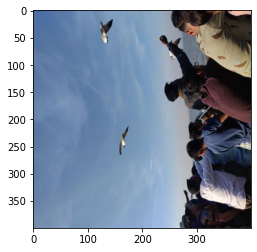

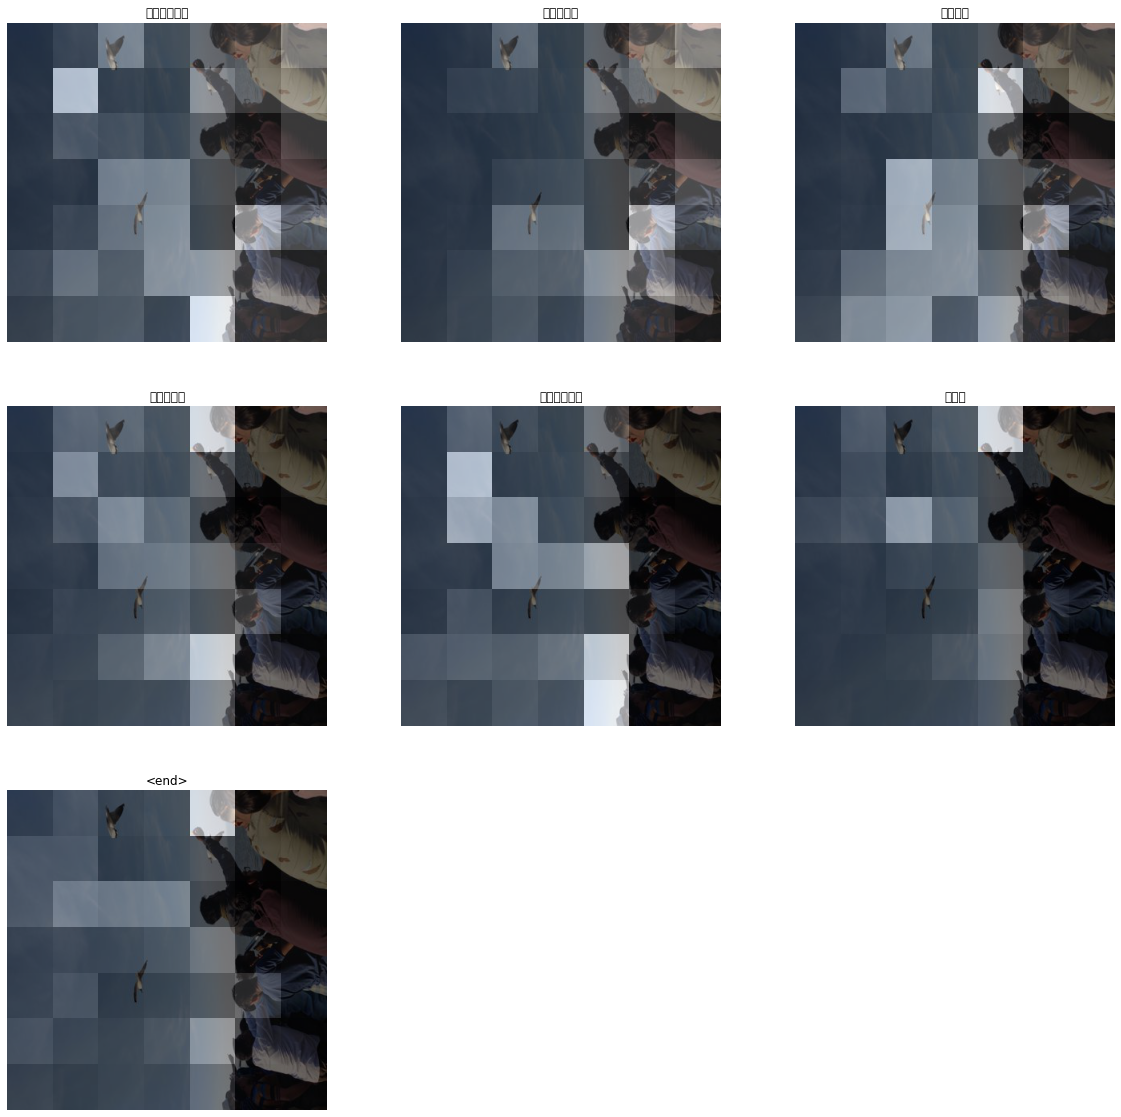

In [98]:
cap_test = bornon_cap_test.copy()
rid = np.random.randint(0, len(bornon_test))
test_image= bornon_test[rid]
real_caption = bornon_cap_test[rid]
result, attention_plot, pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()
temp_img = np.array(Image.open(test_image))
plt.imshow(temp_img)
smooth = SmoothingFunction().method4
bleu1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.37, 0), smoothing_function=smooth)*100
bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
print('BLEU-1: %f' % bleu1)
print('BLEU-2: %f' % bleu2)
print('BLEU-3: %f' % bleu3)
print('BLEU-4: %f' % bleu4)
score = meteor_score(reference,candidate)
print('METEOR Score: %f' % score)
print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attention_map(result, attention_plot, test_image)

In [85]:
b1_test=[]
b2_test=[]
b3_test=[]
b4_test=[]
m_test = []

for rid in range(0,len(bornon_cap_test)):
  test_image= bornon_test[rid]
  real_caption = bornon_cap_test[rid]
  result, attention_plot, pred_test = evaluate(test_image)
  real_caption=filt_text(real_caption)      
  pred_caption=' '.join(result).rsplit(' ', 1)[0]
  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = pred_caption.split()
  smooth = SmoothingFunction().method4
  bleu1 = sentence_bleu(reference, candidate, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
  bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
  bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.37, 0), smoothing_function=smooth)*100
  bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
  b1_test.append(bleu1)
  b2_test.append(bleu2)
  b3_test.append(bleu3)
  b4_test.append(bleu4)
  score = meteor_score(reference,candidate)
  m_test.append(score)

In [86]:
# Zero shot result
print('BLEU-1: %f' % np.mean(b1_test))
print('BLEU-2: %f' % np.mean(b2_test))
print('BLEU-3: %f' % np.mean(b3_test))
print('BLEU-4: %f' % np.mean(b4_test))
print('Meteor Score of zero shot test 2: %f' % np.mean(m_test))

BLEU-1: 24.985879
BLEU-2: 15.854551
BLEU-3: 9.780733
BLEU-4: 7.702065
Meteor Score of zero shot test 2: 0.234471
